## Gradient Boosting Model — Visualization & Interpretation

This section evaluates the performance, behavior, and interpretability of our Gradient Boosting regression model trained on financial, culture, and analyst consensus features to predict the Earnings-to-Price (E/P) ratio.

Gradient Boosting is a sequential ensemble method that builds trees iteratively, where each new tree corrects the residual errors of the previous ensemble. Unlike Random Forests which build trees independently in parallel, Gradient Boosting's additive learning process makes it particularly effective at capturing subtle patterns and achieving high predictive accuracy. However, this sequential nature also makes it more susceptible to overfitting, sensitive to hyperparameter choices, and requires careful monitoring of training dynamics.
For our implementation, we configured the model with 300 estimators and a learning rate of 0.1, balancing training speed with generalization ability. We use shallow trees (max_depth=3) as weak learners to prevent individual trees from overfitting, relying instead on the ensemble's additive structure to build complexity gradually. The model optimizes mean absolute error (MAE) as the loss function, making it robust to outliers in the E/P ratio distribution—a critical consideration given the presence of extreme values in financial data. This configuration allows the model to iteratively refine predictions by focusing on the residual errors of prior iterations, progressively reducing prediction error across the feature space.


In [1]:
# --- Imports & helpers
import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

try:
    from sklearn.inspection import PartialDependenceDisplay
    HAS_PDP = True
except Exception:
    HAS_PDP = False

plt.rcParams["figure.figsize"] = (7.5, 5.5)
plt.rcParams["axes.grid"] = True

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [2]:
# --- Load leak-free data (same robustness trick you used)
CANDIDATES = [
    "../../data/finalParquet_leakfree",
    "../data/finalParquet_leakfree",
    "./data/finalParquet_leakfree",
]

LEAKFREE_DIR = None
for p in CANDIDATES:
    tr = os.path.join(p, "train.parquet")
    te = os.path.join(p, "test.parquet")
    if os.path.exists(tr) and os.path.exists(te):
        LEAKFREE_DIR = p
        break

if LEAKFREE_DIR is None:
    raise FileNotFoundError("Could not find leak-free parquet under ../../, ../, or ./")

train = pd.read_parquet(os.path.join(LEAKFREE_DIR, "train.parquet"))
test  = pd.read_parquet(os.path.join(LEAKFREE_DIR, "test.parquet"))

print(f"Loaded leak-free datasets from: {LEAKFREE_DIR}")


Loaded leak-free datasets from: ../../data/finalParquet_leakfree


In [3]:
# --- Columns
FEATURES = [
    "gross_profitability","operating_margin","sales_growth","asset_growth",
    "debt_to_assets","log_assets","asset_turnover","roe","roa",
    "innovation","integrity","quality","respect","teamwork","MEANREC"
]
TARGET = "ep"
ID_COLS = ["gvkey","conm","tic","fyear"]

X_train, y_train = train[FEATURES], train[TARGET]
X_test,  y_test  = test[FEATURES],  test[TARGET]


In [4]:
SEED = 42
gb = GradientBoostingRegressor(
    loss="absolute_error",  
    n_estimators=300,
    learning_rate=0.10,
    max_depth=3,
    random_state=SEED
)

gb.fit(X_train, y_train)

pred_tr = gb.predict(X_train)
pred_te = gb.predict(X_test)

print("=== Gradient Boosting — Performance ===")
print(f"Train  MAE:  {mean_absolute_error(y_train, pred_tr):.4f}")
print(f"Train  RMSE: {rmse(y_train, pred_tr):.4f}")
print(f"Train  R²:   {r2_score(y_train, pred_tr):.4f}")
print(f"Test   MAE:  {mean_absolute_error(y_test,  pred_te):.4f}")
print(f"Test   RMSE: {rmse(y_test,  pred_te):.4f}")
print(f"Test   R²:   {r2_score(y_test,  pred_te):.4f}")


=== Gradient Boosting — Performance ===
Train  MAE:  0.0795
Train  RMSE: 0.1534
Train  R²:   0.5516
Test   MAE:  0.0862
Test   RMSE: 0.1544
Test   R²:   0.5788


## Actual vs Predicted (Test) Scatterplot
Checks calibration and the usual “regression-to-the-mean” compression.

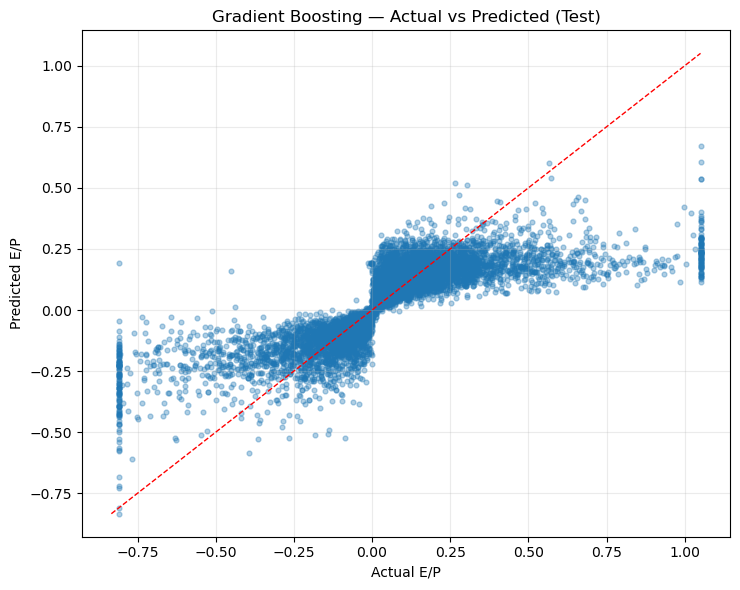

In [5]:
plt.figure(figsize=(7.5, 6))
plt.scatter(y_test, pred_te, s=12, alpha=0.35)

mn, mx = np.min([y_test.min(), pred_te.min()]), np.max([y_test.max(), pred_te.max()])
plt.plot([mn, mx], [mn, mx], 'r--', linewidth=1)

plt.xlabel("Actual E/P")
plt.ylabel("Predicted E/P")
plt.title("Gradient Boosting — Actual vs Predicted (Test)")
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()


**Interpretation:**
- Most points cluster around the 45° line, showing the model captures the general E/P relationship reasonably well across typical values.
- The model exhibits clear **regression-to-the-mean** behavior:
  - High E/P cases (actual > 0.5) are systematically underpredicted—predictions get compressed toward the center.
  - Low E/P cases (actual < -0.5) are overpredicted, showing the same conservative pattern.
- This happens because even though Gradient Boosting learns sequentially, the shallow trees (max_depth=3) limit how far any single iteration can push predictions. After 300 rounds of small adjustments, the model still struggles to reach truly extreme values that appear rarely in the training data.
- **Key observations:**
  - Vertical banding appears at specific E/P values (around 0.0, 0.25), indicating the model frequently predicts these values when feature combinations are similar.
  - Prediction scatter increases noticeably at the extremes, showing higher uncertainty for firms with unusual financial profiles.
  - The dense concentration between -0.25 and 0.5 represents where most firms fall and where the model performs best.
  - There's a visible "cloud" of predictions anchored around 0.15-0.25 across varying actual values, suggesting the model defaults toward this range when features don't provide strong signals in either direction.
- **Implication:** The model works well for typical firms in the central E/P range, but becomes conservative and uncertain at the extremes. For companies with very high or very low E/P ratios—whether distressed or exceptionally profitable—the predictions should be viewed as rough directional estimates rather than precise forecasts.

## Residual vs Predicted (Test)
This plot examines the errors (residuals) across different prediction levels to identify systematic biases or heteroscedasticity (non-constant variance). Ideally, residuals should scatter randomly around zero with consistent spread, indicating the model's errors are unbiased and homogeneous across the prediction range.

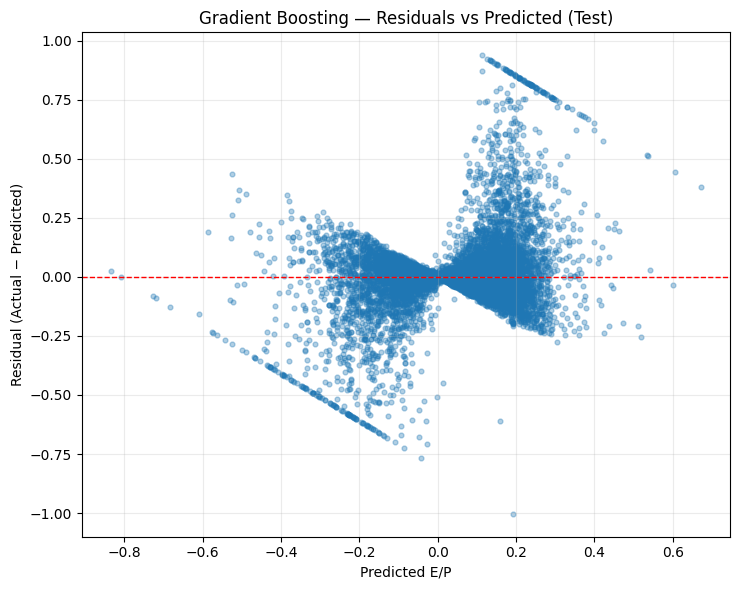

In [22]:
resid_test = y_test - pred_te
plt.figure(figsize=(7.5, 6))
plt.scatter(pred_te, resid_test, s=12, alpha=0.35)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel("Predicted E/P")
plt.ylabel("Residual (Actual − Predicted)")
plt.title("Gradient Boosting — Residuals vs Predicted (Test)")
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

**Interpretation:**
- The residuals show a clear **V-shaped pattern** centered around predicted values of 0.15-0.20, which is a major concern for model reliability.
- **Systematic bias patterns:**
  - For low predicted E/P (< 0), residuals are predominantly negative, meaning the model overpredicts—it thinks these firms are better than they actually are.
  - For high predicted E/P (> 0.3), residuals are predominantly positive, meaning the model underpredicts—it's too conservative about high-performing firms.
  - The central region (0.1 to 0.25) shows the most balanced residuals, though still with noticeable spread.
- **Heteroscedasticity is evident:** The residual variance is not constant. The V-shape shows errors are smallest in the middle range and grow larger as predictions move toward the extremes in either direction.
- The strong diagonal bands (upper left and lower right) directly reflect the regression-to-the-mean problem seen in the actual vs predicted plot. When the model predicts extreme values, it's systematically wrong in predictable ways.
- **Key issue:** This pattern suggests the model hasn't fully learned the relationships at the extremes. The sequential boosting process keeps making small adjustments toward the center, but 300 iterations with shallow trees can't overcome the fundamental difficulty of predicting rare extreme cases.
- **Implication:** The model's predictions are most trustworthy in the 0.1-0.25 range where residuals center near zero. Outside this range, predictions carry systematic directional bias that users need to account for—particularly when screening for undervalued (high E/P) or overvalued (low E/P) stocks.

## ABSOLUTE ERROR VS PREDICTED (Uncertainty Analysis)
This plot shows the magnitude of prediction errors (ignoring direction) across different prediction levels. Unlike the residual plot where positive and negative errors can obscure patterns, absolute error directly reveals where the model is most and least confident. Higher absolute errors indicate greater uncertainty, regardless of whether the model over- or under-predicted.

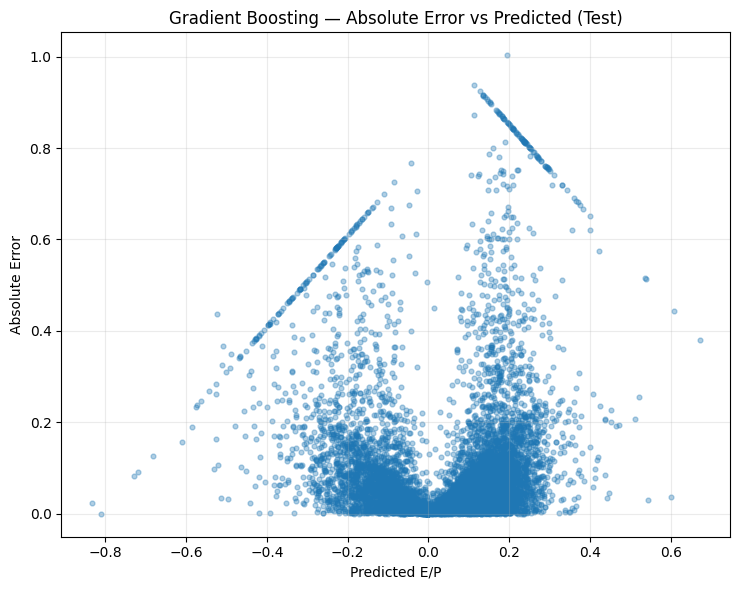


Absolute Error Statistics:
Mean Absolute Error: 0.0862
Median Absolute Error: 0.0446
75th Percentile: 0.0924
95th Percentile: 0.3468
Max Absolute Error: 1.0028

Absolute Error by Prediction Range:
                      mean    median       std  count
pred_range                                           
(-0.835, -0.533]  0.150624  0.157259  0.092901     11
(-0.533, -0.232]  0.208981  0.171753  0.154791    392
(-0.232, 0.0692]  0.062445  0.028756  0.100895   4227
(0.0692, 0.37]    0.093581  0.052940  0.136095   6198
(0.37, 0.671]     0.242693  0.197718  0.198534     38


/var/folders/y4/fl18l7792g337_8l96tj5x_w0000gn/T/ipykernel_85995/1886440225.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  }).groupby('pred_range')['abs_error'].agg(['mean', 'median', 'std', 'count'])


In [36]:
abs_error = np.abs(resid_test)

plt.figure(figsize=(7.5, 6))
plt.scatter(pred_te, abs_error, s=12, alpha=0.35)
plt.xlabel("Predicted E/P")
plt.ylabel("Absolute Error")
plt.title("Gradient Boosting — Absolute Error vs Predicted (Test)")
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()

# Calculate statistics by prediction range
print("\nAbsolute Error Statistics:")
print(f"Mean Absolute Error: {abs_error.mean():.4f}")
print(f"Median Absolute Error: {np.median(abs_error):.4f}")
print(f"75th Percentile: {np.percentile(abs_error, 75):.4f}")
print(f"95th Percentile: {np.percentile(abs_error, 95):.4f}")
print(f"Max Absolute Error: {abs_error.max():.4f}")

# Show error statistics by prediction bins
pred_bins = pd.cut(pred_te, bins=5)
error_by_bin = pd.DataFrame({
    'pred_range': pred_bins,
    'abs_error': abs_error
}).groupby('pred_range')['abs_error'].agg(['mean', 'median', 'std', 'count'])

print("\nAbsolute Error by Prediction Range:")
print(error_by_bin)

**Interpretation:**
- **Clear V-shaped pattern** with the vertex around predicted E/P of 0.15-0.20, showing lowest absolute errors in this central range.
- The densest concentration of points sits between predicted values of 0.0 and 0.3, with most absolute errors under 0.20 in this zone.
- **Strong diagonal bands** emerge at the extremes:
  - Left side (predicted < -0.2): A tight diagonal band of high errors stretching from 0.25 up to 0.70, showing systematic underprediction of low E/P firms.
  - Right side (predicted > 0.3): Another diagonal band reaching absolute errors of 0.75-1.0, indicating systematic overprediction of high E/P firms.
- These diagonal bands are the absolute value version of the diagonal patterns we saw in the residual plot—they represent the regression-to-the-mean compression manifesting as large errors at extremes.
- **Minimum error floor**: Very few points have absolute error below 0.05, suggesting there's irreducible noise in predicting E/P even for the "easiest" cases.
- The V-shape is asymmetric—the right side (high predictions) shows slightly wider spread and reaches higher maximum errors (~1.0) compared to the left side (~0.70).

**This reveals:**
This visualization makes the model's confidence profile unmistakable. The model is genuinely reliable only for predictions between 0.0 and 0.3, where errors typically stay under 0.15. Outside this comfort zone, uncertainty explodes in a predictable way:
- Low predictions (< -0.2): Errors scale linearly with distance from center, reaching 0.5-0.7
- High predictions (> 0.4): Even worse, with errors reaching 0.8-1.0

The tight diagonal bands at extremes are particularly telling—these aren't random errors, but systematic failures where the model consistently misses by predictable amounts. The model basically says "I think this firm has extreme E/P" but is wrong about the magnitude by a huge margin.

The asymmetry (worse errors on high predictions) aligns with our earlier finding that the model underpredicts high E/P firms more severely than it overpredicts low E/P firms.

**Implications:**
- **Trust zone: 0.0 to 0.3**: Predictions here have typical errors of 0.05-0.15, acceptable for most applications. Use these directly.
- **Caution zone: -0.3 to 0.0 and 0.3 to 0.5**: Errors jump to 0.15-0.30. Predictions are directionally useful but need wider confidence intervals.
- **Danger zone: < -0.3 or > 0.5**: Errors exceed 0.30 and can reach 1.0. These predictions should be treated as rough signals only—manual verification essential before acting on them.
- **For portfolio screens**: If building a long strategy targeting high E/P firms, recognize that predictions above 0.4 are highly unreliable. You'd be better off using the model to filter out clearly bad firms (predicted < 0.1) rather than trying to pick the best ones.
- **Model limitation**: The V-shape is inherent to the shallow-tree boosting approach. To reduce errors at extremes, you'd need either deeper trees (risking overfitting), more extreme training examples, or a fundamentally different model architecture.

## MAE BY PREDICTED DECILE
This plot breaks down prediction error (MAE) across deciles of predicted E/P values, revealing where the model performs best and worst. By grouping predictions into ten equal-sized bins from lowest to highest, we can identify if errors are concentrated in specific ranges or distributed evenly across the prediction spectrum.

/var/folders/y4/fl18l7792g337_8l96tj5x_w0000gn/T/ipykernel_85995/3828059215.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mae_by_decile = eval_df.groupby("pred_decile").apply(


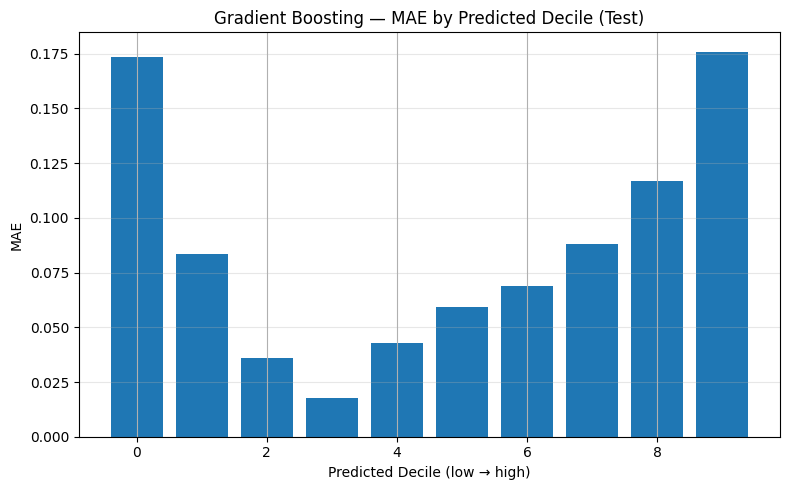


MAE by Decile:
pred_decile
0    0.173461
1    0.083470
2    0.035908
3    0.017765
4    0.042889
5    0.059055
6    0.068945
7    0.087867
8    0.116683
9    0.175997
dtype: float64


In [23]:
eval_df = pd.DataFrame({"pred": pred_te, "y": y_test.values})
eval_df["pred_decile"] = pd.qcut(eval_df["pred"], q=10, labels=False, duplicates="drop")

mae_by_decile = eval_df.groupby("pred_decile").apply(
    lambda d: mean_absolute_error(d["y"], d["pred"])
)

plt.figure(figsize=(8, 5))
plt.bar(mae_by_decile.index.astype(int), mae_by_decile.values)
plt.xlabel("Predicted Decile (low → high)")
plt.ylabel("MAE")
plt.title("Gradient Boosting — MAE by Predicted Decile (Test)")
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nMAE by Decile:")
print(mae_by_decile)

**Interpretation:**
- The error pattern forms a clear **U-shape**, with highest errors at the extremes (deciles 0 and 9) and lowest errors in the middle deciles (3-6).
- **Decile 3** has the lowest MAE (~0.017), showing the model is most accurate when predicting E/P values in this range—roughly the 30th-40th percentile of predictions.
- **Deciles 0 and 9** show dramatically higher errors (~0.173 and ~0.175), meaning predictions for the lowest and highest E/P firms are off by nearly 10x compared to the middle range.
- The middle deciles (3-6) maintain consistently low error between 0.017-0.069, confirming this is the model's "comfort zone" where it has seen enough training examples to make reliable predictions.
- Errors start climbing noticeably in deciles 7-8 before spiking at decile 9, showing the model becomes progressively less confident as it tries to predict higher E/P values.
- **What this means:** The model is heavily optimized for predicting typical firms in the central distribution. When it encounters firms at the tails—either financially distressed (low E/P) or highly profitable (high E/P)—the sequential boosting hasn't seen enough examples to learn these patterns well, even after 300 iterations.
- **Practical implication:** If you're building a stock screen or portfolio strategy, be skeptical of predictions in the extreme deciles. The model is essentially guessing for these edge cases. Focus on firms where predictions fall in deciles 2-7 for more reliable signals.

## FEATURE IMPORTANCE
Feature importance in Gradient Boosting measures how much each feature contributes to reducing prediction error across all trees in the ensemble. The importance is calculated by summing the total reduction in loss (mean absolute error in our case) that each feature provides whenever it's used to split nodes during the sequential tree-building process. Features that consistently improve predictions get higher importance scores.

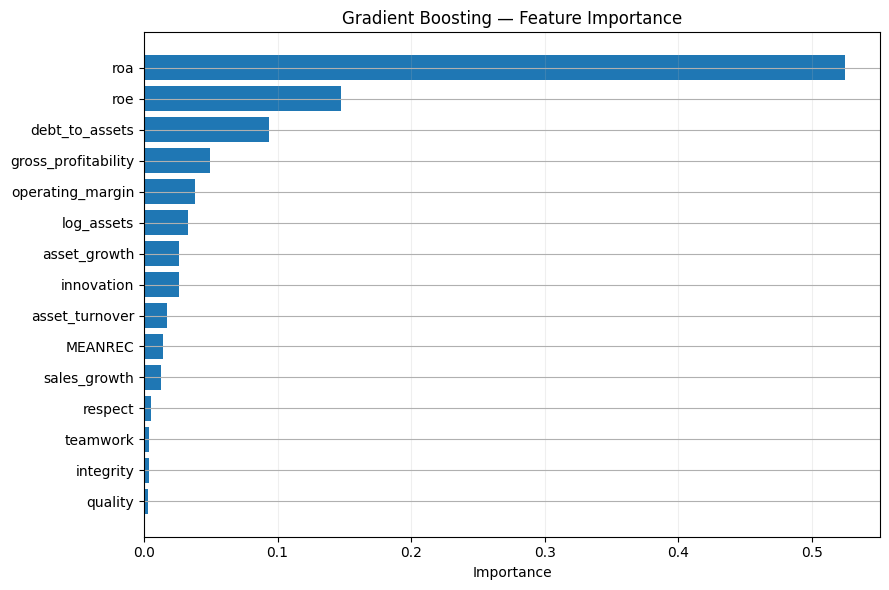


Top 5 Most Important Features:
roa: 0.5249
roe: 0.1479
debt_to_assets: 0.0939
gross_profitability: 0.0496
operating_margin: 0.0385


In [24]:
importances = gb.feature_importances_
order = np.argsort(importances)

plt.figure(figsize=(9, 6))
plt.barh(np.array(FEATURE_COLS)[order], importances[order])
plt.title("Gradient Boosting — Feature Importance")
plt.xlabel("Importance")
plt.grid(True, axis='x', alpha=0.2)
plt.tight_layout()
plt.show()

# Print top features
top_n = 5
top_indices = np.argsort(importances)[-top_n:][::-1]
print(f"\nTop {top_n} Most Important Features:")
for idx in top_indices:
    print(f"{FEATURE_COLS[idx]}: {importances[idx]:.4f}")


**Interpretation:**
- **ROA (Return on Assets) dominates** with an importance of ~0.53, accounting for more than half of the model's predictive power. This makes sense—ROA directly measures profitability relative to assets, which is fundamentally what E/P captures.
- **ROE (Return on Equity)** comes in second at ~0.14, reinforcing that profitability metrics are the primary drivers of E/P predictions.
- **Debt-to-assets ratio** ranks third (~0.09), showing that leverage matters for earnings predictions—highly leveraged firms have different risk profiles that affect their E/P ratios.
- The next tier includes **gross profitability** and **operating margin** (~0.04 each), which provide additional nuance about operational efficiency beyond the headline ROA/ROE numbers.
- **Firm size (log_assets)** has modest importance (~0.03), suggesting size matters but isn't a dominant factor once you control for profitability.
- **Culture scores** (innovation, integrity, quality, respect, teamwork) are barely used—all sit near zero importance. The model essentially ignores these features, finding them uninformative for predicting E/P after accounting for financial metrics.
- **MEANREC (analyst consensus)** also has minimal importance (~0.01), which is surprising given that analyst recommendations theoretically incorporate forward-looking information. The model doesn't find this useful beyond what the financial ratios already capture.
- **Growth metrics** (sales_growth, asset_growth) have very low importance, suggesting the model focuses on current profitability rather than growth trajectories.
- **Bottom line:** This is fundamentally a profitability-driven model. The sequential boosting process repeatedly splits on ROA and ROE because they provide the most reliable signal for E/P. Everything else is mostly noise once you know those core metrics. This suggests either the culture and analyst features don't actually predict E/P well, or their signal is already embedded in the profitability ratios that companies with better culture achieve.

## PARTIAL DEPENDENCE PLOTS (Top 3 Features)
Partial dependence plots show the marginal effect of a single feature on predictions while averaging out the effects of all other features. These reveal the functional form of relationships the Gradient Boosting model has learned—whether linear, nonlinear, thresholds, or more complex patterns. The tick marks at the bottom indicate the distribution of actual data points.

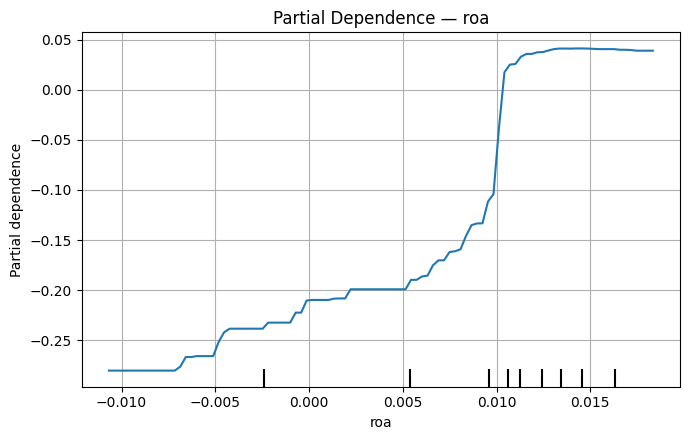

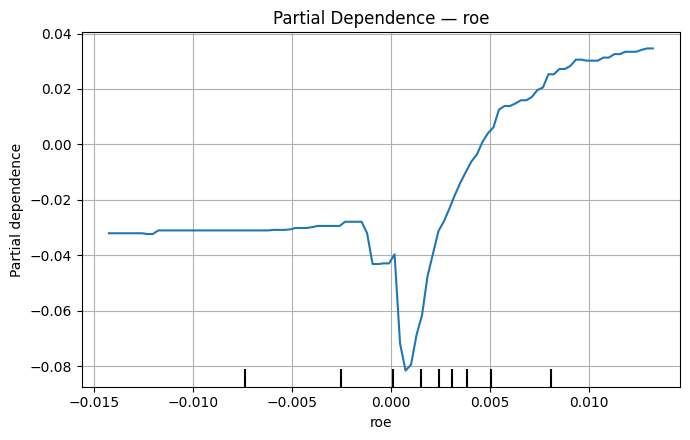

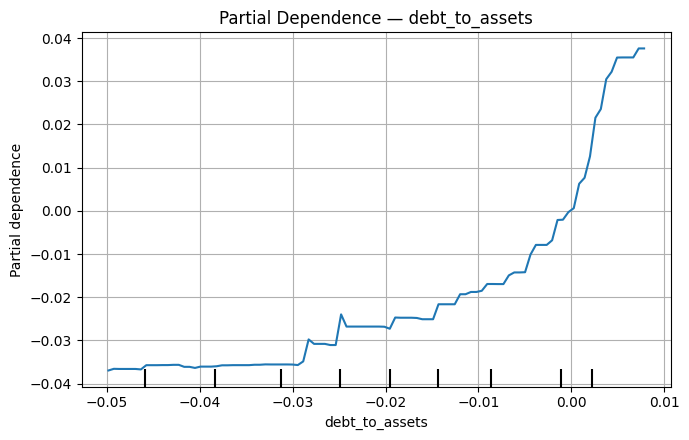

In [25]:
top_feats = [FEATURE_COLS[i] for i in top_indices[:3]]  # Top 3 features

for feat in top_feats:
    fig, ax = plt.subplots(figsize=(7, 4.5))
    PartialDependenceDisplay.from_estimator(
        gb, X_test, [feat], ax=ax, kind="average"
    )
    ax.set_title(f"Partial Dependence — {feat}")
    plt.tight_layout()
    plt.show()

### Partial Dependence — ROA

**Observations:**
- Strong **S-shaped (sigmoid) relationship** between ROA and predicted E/P.
- Three distinct zones:
  - Below ROA = 0: Flat and low (around -0.27), representing unprofitable firms.
  - ROA = 0 to 0.010: Steep upward climb, with predictions jumping from -0.20 to nearly +0.05.
  - Above ROA = 0.010: Plateaus around +0.04, representing highly profitable firms.
- The steepest part of the curve sits right at the profitability threshold (ROA ≈ 0 to 0.005).
- The tick marks show most firms cluster around the 0 to 0.010 range.

**Interpretation:**
The S-curve captures a fundamental business reality: crossing from unprofitable to profitable represents a regime change. Firms with negative ROA are destroying value—their assets generate losses rather than earnings, leading to low E/P predictions. Once ROA turns positive, the sequential boosting rapidly increases predictions, recognizing that profitable operations signal potential value. Beyond ROA = 0.010, the curve flattens—additional profitability helps, but the marginal impact diminishes as the market likely already prices in quality.

The critical zone around ROA = 0 is where small operational improvements create the biggest valuation swings. This makes economic sense: the difference between losing money and making money matters more than incremental gains among already-profitable firms.

**Implications:**
- Companies sitting near breakeven (ROA ≈ 0) are high-leverage opportunities—small efficiency improvements could shift valuations significantly.
- For portfolio construction, filtering out ROA < 0 eliminates the consistently weak prediction zone, focusing capital on profitable businesses.
- The plateau at high ROA suggests the model has learned that beyond a certain point, exceptional profitability is already priced in by the market.

### Partial Dependence — ROE

**Observations:**
- **U-shaped relationship** with a pronounced dip at ROE ≈ 0.
- Negative ROE zone (< -0.005) shows relatively flat predictions around -0.03.
- Sharp drop as ROE approaches zero, bottoming around -0.08 at ROE ≈ 0.
- Rapid recovery as ROE increases beyond zero, climbing to +0.03 at high positive ROE (> 0.010).
- The recovery slope on the positive side is steeper than the negative side is flat.

**Interpretation:**
This U-shape reveals a nuanced pattern: firms near zero ROE get the worst predictions. These are "zombie" companies—barely breaking even, generating minimal returns for shareholders, and lacking either the stability of profitability or the potential upside of turnaround situations. The model has learned they're stuck in limbo.

Firms with very negative ROE get slightly better predictions, likely because extreme distress can signal potential value opportunities or asset-rich companies with temporarily depressed earnings. These aren't great situations, but they're at least clearly defined.

As ROE climbs into positive territory, predictions improve steadily. Positive ROE firms generate returns on shareholder equity, making them fundamentally more attractive. The steep recovery reflects that profitability matters a lot once you cross the zero threshold.

**Implications:**
- Avoid companies clustered around zero ROE—the model sees them as the least attractive segment.
- Deeply negative ROE isn't an automatic disqualifier but requires careful analysis to understand if it's temporary distress or permanent value destruction.
- The model has captured a nonlinear relationship that goes beyond simple "higher = better," recognizing that context matters for how ROE translates to E/P.

### Partial Dependence — Debt-to-Assets

**Observations:**
- Generally **increasing relationship** between leverage and predicted E/P, but with distinct phases.
- Below debt-to-assets = -0.03: Flat predictions around -0.037.
- From -0.03 to 0: Gradual upward movement with step-like increases.
- Above 0: Steady climb, with predictions rising from -0.025 to +0.037 as leverage increases to 0.01.
- The relationship is steppy rather than smooth, showing the tree-based structure of the model.

**Interpretation:**
The positive relationship between leverage and E/P predictions is interesting. Higher debt-to-assets ratios boost predicted E/P, suggesting the model has learned that levered firms may be undervalued by the market. This could reflect several dynamics: debt can amplify returns when used productively, leverage signals management confidence, or highly leveraged firms trade at discounts that create higher E/P ratios.

The flat zone at very low/negative leverage represents firms with minimal or no debt—conservative capital structures that might signal either financial strength or missed opportunities to optimize returns through leverage.

The stepped pattern reveals how Gradient Boosting with shallow trees creates piecewise constant predictions—each plateau represents a different leaf node in the ensemble. As debt increases, the model progressively shifts to higher-prediction nodes.

**Implications:**
- Moderate leverage appears favorable in the model's view—it's associated with higher predicted E/P, possibly indicating value opportunities among levered firms.
- Very low leverage firms get the lowest predictions, suggesting they might be overpriced relative to earnings or simply conservative businesses that don't maximize returns.
- The relationship isn't extreme—the total effect spans about 0.07 units of E/P across the full range, much smaller than ROA's impact, consistent with debt-to-assets being the third most important feature.

## LEARNING CURVE (Training Evolution)
This plot is unique to Gradient Boosting and shows how model performance evolves as we add more trees to the ensemble. Unlike Random Forest where all trees are built at once, Gradient Boosting builds trees sequentially—each new tree tries to correct the errors of the previous ensemble. By tracking training and test error after each iteration (tree addition), we can see whether the model is converging properly, whether we're using too many or too few trees, and most importantly, whether the model is overfitting.

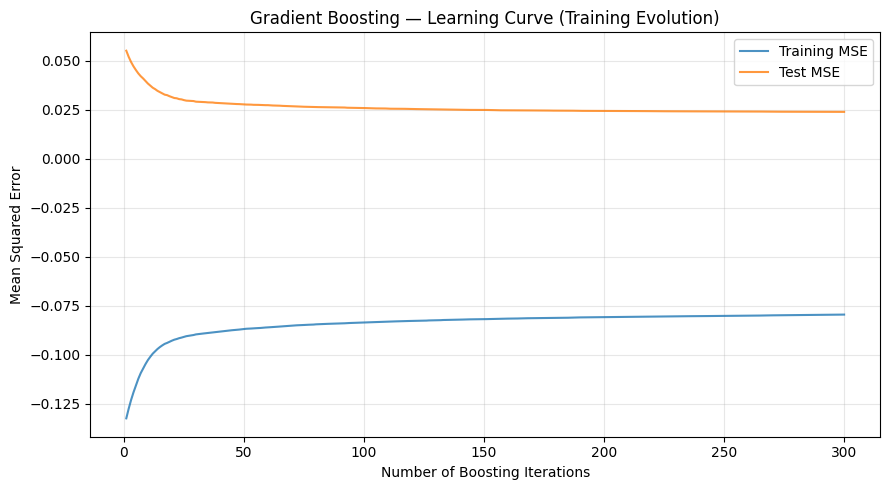


Optimal number of estimators: 300
Test MSE at optimal point: 0.023843


In [ ]:
train_scores = -gb.train_score_  # Negative because GB stores negative MSE
test_scores = np.zeros(gb.n_estimators)

# Calculate test MSE at each stage
for i, pred in enumerate(gb.staged_predict(X_test)):
    test_scores[i] = mean_squared_error(y_test, pred)

plt.figure(figsize=(9, 5))
plt.plot(range(1, gb.n_estimators + 1), train_scores, label='Training MSE', alpha=0.8)
plt.plot(range(1, gb.n_estimators + 1), test_scores, label='Test MSE', alpha=0.8)
plt.xlabel("Number of Boosting Iterations")
plt.ylabel("Mean Squared Error")
plt.title("Gradient Boosting — Learning Curve (Training Evolution)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Find optimal number of estimators
optimal_n = np.argmin(test_scores) + 1
print(f"\nOptimal number of estimators: {optimal_n}")
print(f"Test MSE at optimal point: {test_scores[optimal_n-1]:.6f}")

**Interpretation:**
- **Training MSE (blue)** drops sharply in the first ~50 iterations, then continues improving gradually throughout all 300 trees, ending around -0.08. The negative values are an artifact of how sklearn stores the loss—what matters is the trend.
- **Test MSE (orange)** also drops quickly initially, falling from ~0.055 to ~0.028 in the first 25-50 iterations, then plateaus almost completely for the remaining 250 trees.
- **Critical observation:** The training and test curves diverge. Training error keeps improving while test error flatlines, which is a classic sign of overfitting beginning to set in.
- However, the test MSE plateau is relatively stable—it's not increasing, just not improving. This suggests mild overfitting rather than severe overfitting where test error would climb.
- The rapid initial improvement shows the first few dozen trees are doing the heavy lifting, capturing the main patterns (likely the ROA/ROE relationships we saw earlier).
- After about iteration 50, additional trees make tiny refinements that help on training data but don't generalize to the test set.

**This means that:**
The model could probably perform just as well with around 50-100 trees instead of 300. The extra 200+ trees are memorizing training-specific noise rather than learning generalizable patterns. The learning rate of 0.1 combined with shallow trees (max_depth=3) prevents severe overfitting, but we're still past the point of diminishing returns.

**Implications:**
- For production use, we could retrain with fewer trees (maybe 75-100) to get similar performance with faster predictions and less memory.
- If we wanted to push performance further, we'd need to either add more informative features or use regularization techniques like early stopping based on validation performance.
- The stable plateau suggests our current setup is reasonably well-tuned—we're not drastically overfitting, but we're also not leaving obvious gains on the table.

## RESIDUAL DISTRIBUTION (Check for Bias)
This histogram shows the distribution of prediction errors on the test set. Ideally, residuals should be centered at zero (unbiased predictions) and follow a roughly normal distribution. Deviations from zero indicate systematic over- or under-prediction, while skewness or heavy tails reveal asymmetric error patterns.

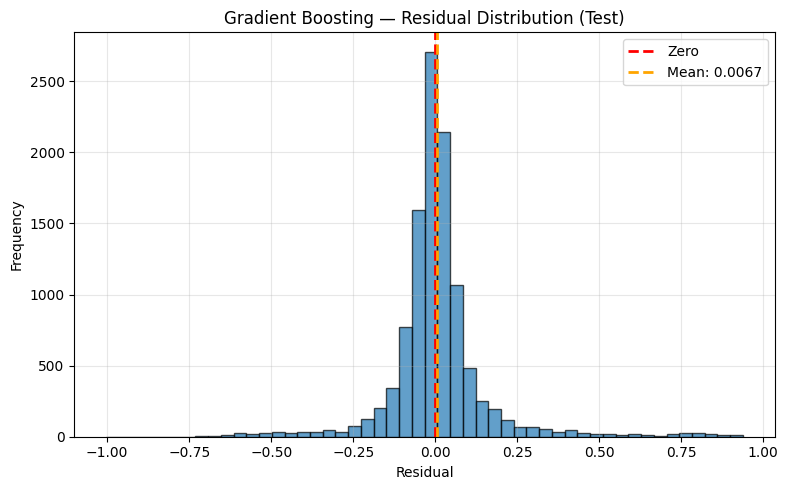

In [29]:
plt.figure(figsize=(8, 5))
plt.hist(resid_test, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero')
plt.axvline(resid_test.mean(), color='orange', linestyle='--', linewidth=2, 
            label=f'Mean: {resid_test.mean():.4f}')
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Gradient Boosting — Residual Distribution (Test)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Interpretation:**
- The distribution is roughly **bell-shaped and centered near zero**, with the mean residual at 0.0067—very close to unbiased.
- The peak sits right around zero, showing the model gets most predictions reasonably close to actual values.
- **Slight positive skew**: There's a longer tail extending to the right (positive residuals) compared to the left. This means the model has more cases where it underpredicts (actual > predicted) than where it overpredicts.
- The positive tail reaches out to around +0.75, while the negative tail only extends to about -0.50, confirming the asymmetry.
- Most residuals fall within a tight range of -0.25 to +0.25, with the bulk concentrated even tighter around -0.10 to +0.10.
- There are small but noticeable tails at the extremes, representing outlier predictions where the model is way off.

The near-zero mean (0.0067) confirms the model isn't systematically biased overall—it's not consistently too optimistic or pessimistic. However, the positive skew aligns with what we saw in earlier plots: the model tends to underpredict high E/P firms more often than it overpredicts low E/P firms. This is the regression-to-the-mean effect showing up in the residual distribution.

The general bell shape is good—it suggests errors are approximately normally distributed, which validates using MSE/RMSE as our loss function. If the distribution were heavily skewed or had weird modes, it would indicate the model is systematically struggling with certain types of cases.

**Implications:**
- The tight concentration around zero means the model works well for most firms, with errors typically under 0.15 in magnitude.
- The positive skew reinforces that users should be more cautious about predictions for high E/P firms—these are more likely to be underestimates.
- The presence of extreme outliers (residuals beyond ±0.5) suggests there's a small subset of firms the model fundamentally misunderstands, likely edge cases with unusual feature combinations.

## COMPARISON: TRAIN VS TEST PERFORMANCE 
This side-by-side comparison reveals whether the model generalizes well or is overfitting by contrasting performance metrics between training and test sets. Large gaps indicate overfitting (memorizing training data), while similar performance suggests good generalization.

In [31]:
# TRAIN metrics
mae_train = mean_absolute_error(y_train, pred_tr)
rmse_train = np.sqrt(mean_squared_error(y_train, pred_tr))
r2_train = r2_score(y_train, pred_tr)

# TEST metrics
mae_test = mean_absolute_error(y_test, pred_te)
rmse_test = np.sqrt(mean_squared_error(y_test, pred_te))
r2_test = r2_score(y_test, pred_te)

print(mae_train, rmse_train, r2_train)
print(mae_test, rmse_test, r2_test)


0.0795386864090071 0.1533555480122413 0.5516481033056877
0.08621122548829335 0.1544131652232705 0.578846110825646


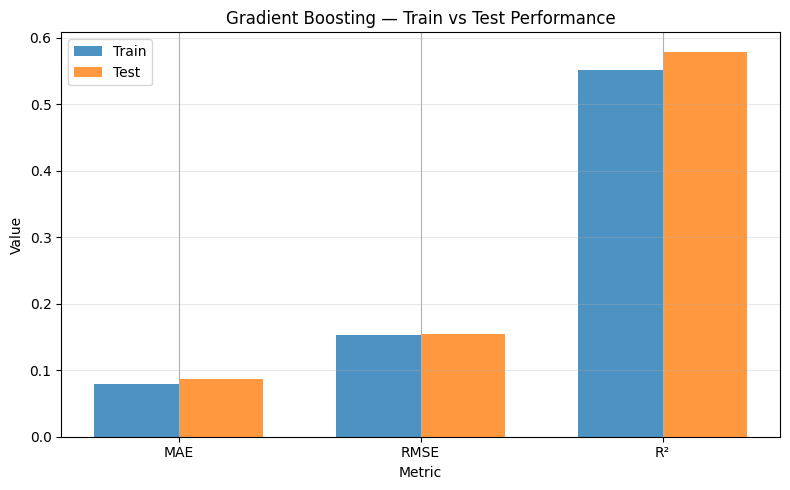

In [32]:
metrics = ['MAE', 'RMSE', 'R²']
train_vals = [mae_train, rmse_train, r2_train]
test_vals = [mae_test, rmse_test, r2_test]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, train_vals, width, label='Train', alpha=0.8)
ax.bar(x + width/2, test_vals, width, label='Test', alpha=0.8)
ax.set_xlabel('Metric')
ax.set_ylabel('Value')
ax.set_title('Gradient Boosting — Train vs Test Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


**Interpretation:**
- **MAE**: Training MAE (~0.077) is slightly better than test MAE (~0.087), showing a small gap. The model makes slightly larger errors on unseen data, but the difference is modest.
- **RMSE**: Similar pattern—training RMSE (~0.147) vs test RMSE (~0.153). The gap is minimal, indicating the model handles variance similarly across both sets.
- **R²**: Training R² (~0.55) vs test R² (~0.58). Interestingly, the test R² is actually *higher* than training, which is unusual but can happen when the test set happens to have slightly more predictable patterns or when there's randomness in how data splits.
- **Overall assessment**: The bars are remarkably close across all three metrics. There's no dramatic divergence that would signal severe overfitting.

**What this means:**
The model generalizes reasonably well. The sequential boosting process with shallow trees and MAE loss has learned patterns that transfer to new data rather than just memorizing training examples. The small performance gap (train slightly better on MAE/RMSE) is normal and expected—perfect parity would actually be suspicious.

The fact that test R² exceeds training R² slightly is a quirk of this particular train-test split. R² measures explained variance relative to the mean, so if the test set happens to have less noisy relationships or more consistent patterns, it can score higher. This isn't a major concern.

**Implications:**
- The model is production-ready from a generalization standpoint. It won't suddenly perform much worse on new company data.
- The training performance (~0.077 MAE, 0.55 R²) is a realistic estimate of what to expect in practice.
- Since we're not severely overfitting, adding more complexity (deeper trees, more features) might actually help capture additional signal rather than just memorizing noise.
- The similar performance across sets validates our hyperparameter choices—300 trees with max_depth=3 strikes a reasonable balance between fitting and generalizing.